In [33]:
%matplotlib inline

import tensorflow as tf


def is_gpu_available():
    return tf.config.list_physical_devices('GPU')


print("TensorFlow version:", tf.__version__)
print(f"GPU is{' ' if tf.config.list_physical_devices('GPU') else ' not '}available on the device")


IMAGES = 7400
API_KEY = "24844585-de839c0e13ca422a989916f16"

TensorFlow version: 2.7.0
GPU is not available on the device


In [ ]:
def remove_axis(plt):
  plt.axes.xaxis.set_visible(False)
  plt.axes.yaxis.set_visible(False)

def print_images_from_dir(path: str):
  fig, axes = subplots(1, 5, figsize=(15, 15))
  for ind, ax in enumerate(axes):
    remove_axis(ax)
    ax.imshow(imread(f"{path}/img{ind}.jpg"))
  display(fig)
  close()

In [13]:
from os import makedirs, listdir, remove, system
from shutil import rmtree, move
from tqdm.notebook import trange, tqdm
from pandas import read_csv
from requests import get
from matplotlib.pyplot import subplots, imread, close
#from google.colab import drive
from IPython.display import display
from torch.utils.data import random_split


# https://pixabay.com/api/?key={{YOUR_API_KEY}}&image_type=photo&q={{WORD}}&per_page=100&page={{PAGE_NUMBER}}
# has[]=photos&quality_grade=any&identifications=any&iconic_taxa[]=Plantae&projects[]=leningrad-oblast-flora
# has[]=photos&quality_grade=any&identifications=any&iconic_taxa[]=Plantae&taxon_id=499936


def clear_path(path: str) -> str:
  rmtree(path, ignore_errors=True)
  makedirs(path)
  return path


def print_images(path: str):
  figure, axes = subplots(1, 5, figsize=(15, 15))
  for ind, ax in enumerate(axes):
    remove_axis(ax)
    ax.imshow(imread(f"{path}/img{ind}.jpg"))
  figure.show()
  display(figure)
  close()


def split_set(dir):
  only_set = listdir(f"./drive/MyDrive/Hogweb/train/{dir}")
  train_set, test_set = random_split(only_set, [int(0.8 * len(only_set)), int(0.2 * len(only_set))])
  for file in test_set:
    move(f"./drive/MyDrive/Hogweb/train/{dir}/{file}", f"./drive/MyDrive/Hogweb/test/{dir}/{file}")


#drive.mount("./drive")
print(f"Train set should contain {IMAGES} hogweed and {IMAGES} other plants images, should also contain {IMAGES} miscellaneous images")

print("Preparing 'train' directory")
clear_path("./drive/MyDrive/Hogweb/train/hogweed")
clear_path("./drive/MyDrive/Hogweb/train/cetera")
clear_path("./drive/MyDrive/Hogweb/train/other")

frame = read_csv("./drive/MyDrive/Hogweb/hogweed.csv")

print(f"Downloading hogweed images from iNaturalist ({IMAGES})")
for index, url in zip(trange(IMAGES, desc="Downloading", unit="img"), frame["image_url"].sample(IMAGES)):
  with open(f"./drive/MyDrive/Hogweb/train/hogweed/img{index}.jpg", "wb") as f:
    f.write(get(url).content)

print("iNaturalist dataset hogweed photo samples:")
print_images("./drive/MyDrive/Hogweb/train/hogweed")

frame = read_csv("./drive/MyDrive/Hogweb/regional.csv")

print(f"Downloading cetera images from iNaturalist ({IMAGES})")
for index, url in zip(trange(IMAGES, desc="Downloading", unit="img"), frame[frame["scientific_name"] != "Heracleum sosnowskyi"]["image_url"].sample(IMAGES)):
  with open(f"./drive/MyDrive/Hogweb/train/cetera/img{index}.jpg", "wb") as f:
    f.write(get(url).content)

print("iNaturalist dataset other plants photo samples:")
print_images("./drive/MyDrive/Hogweb/train/cetera")

print(f"Downloading other train images from Pixabay ({IMAGES})")
urls = []
words = ["emotion", "television", "mall", "science", "addition", "analyst", "manufacturer", "song", "cheek", "flight", "aspect", "profession", "payment", "president", "preparation", "love", "climate", "desk", "security", "storage"]
for word in words:
  for i in range(5):
    urls += list(map(lambda obj: obj["webformatURL"], get(f"https://pixabay.com/api/?key={API_KEY}&image_type=photo&q={word}&per_page=100&page={i + 1}").json()["hits"]))
for index, url in zip(trange(IMAGES, desc="Downloading", unit="img"), urls):
  with open(f"./drive/MyDrive/Hogweb/train/other/img{index}.jpg", "wb") as f:
    f.write(get(url).content)

print("Pixabay dataset miscellaneous photo samples:")
print_images("./drive/MyDrive/Hogweb/train/other")

print("Preparing 'test' directory")
clear_path("./drive/MyDrive/Hogweb/test/hogweed")
clear_path("./drive/MyDrive/Hogweb/test/cetera")
clear_path("./drive/MyDrive/Hogweb/test/other")

print("Filling with hogweed photos")
split_set("hogweed")
print("Filling with cetera photos")
split_set("cetera")
print("Filling with other photos")
split_set("other")

#drive.flush_and_unmount()

print("Removing ipynb caches")
system("rm -rf `find -type d -name .ipynb_checkpoints`")

Train set should contain 7400 hogweed and 7400 other plants images, should also contain 7400 miscellaneous images
Preparing 'train' directory


FileNotFoundError: [Errno 2] No such file or directory: './drive/MyDrive/Hogweb/hogweed.csv'

In [ ]:
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ColorJitter, RandomHorizontalFlip, Compose, RandomAffine, ToTensor, Normalize
from matplotlib.pyplot import figure, imshow, gca
from numpy import hstack, transpose
#from google.colab import drive


#drive.mount("./drive")

train_transform = Compose([
    Resize((224, 224)),
    ColorJitter(hue=0.05, saturation=0.05),
    RandomHorizontalFlip(),
    RandomAffine(25, interpolation=InterpolationMode.BILINEAR),
    ToTensor()
])
test_transform = Compose([Resize((224, 224)), ToTensor()])

# iNaturalist train set: ./drive/MyDrive/Hogweb/train
# iNaturalist test set: ./drive/MyDrive/Hogweb/test
# User test set: ./drive/MyDrive/Hogweed/test

train_set = ImageFolder("./drive/MyDrive/Hogweb/train", transform=train_transform)
ideal_set = ImageFolder("./drive/MyDrive/Hogweb/test", transform=test_transform)
user_set = ImageFolder("./drive/MyDrive/Hogweed/test", transform=test_transform)

print(f"Train set has {len(train_set)} images, test set has {len(ideal_set) + len(user_set)} images; train set will be augmented:")
figure(figsize=(15, 25))
remove_axis(gca())
imshow(hstack([transpose(hstack([train_set[0][0], train_set[1][0], train_set[2][0], train_set[3][0]]), (1, 2, 0)) for _ in range(6)]))

train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
ideal_dataloader = DataLoader(ideal_set, batch_size=32, shuffle=True)
user_dataloader = DataLoader(user_set, batch_size=32, shuffle=True)

#drive.flush_and_unmount()

In [ ]:
from torch.nn import Linear
from tqdm.notebook import tqdm
from torch import no_grad
from torchvision.models import resnet101
from matplotlib.pyplot import subplots, close
from IPython.display import display, update_display


def redraw_graph(drawable, losses_arr, accuracy_arr):
  title = drawable[1].get_title()
  x_label = drawable[1].get_xlabel()
  y_label = drawable[1].get_ylabel()

  drawable[1].cla()
  drawable[1].plot(losses_arr, color="blue", label="losses")
  drawable[1].scatter(len(losses_arr) - 1, losses_arr[-1], c="blue")
  drawable[1].plot(accuracy_arr, color="red", label="accuracy")
  drawable[1].scatter(len(accuracy_arr) - 1, accuracy_arr[-1], c="red")

  drawable[1].set_ylim(bottom=0)
  drawable[1].set_title(title)
  drawable[1].set_xlabel(x_label)
  drawable[1].set_ylabel(y_label)
  drawable[1].legend()
  drawable[1].grid(visible=True)

  drawable[0].show()
  update_display(drawable[0], display_id=drawable[2])


def train_epoch(model, data_loader, optimizer, criterion, device, losses_arr, accuracy_arr, drawable):
  model = model.to(device).train()
  total_loss = 0
  total_accuracy = 0
  with tqdm(desc="Training", unit="batch", total=len(data_loader)) as prbar:
    for images, labels in data_loader:
      # Move Batch to GPU
      images = images.to(device)
      labels = labels.to(device)
      predicted = model(images)
      loss = criterion(predicted, labels)
      # Update weights
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      # Update descirption for tqdm
      accuracy = (predicted.argmax(1) == labels).float().mean()
      prbar.set_description(f"Loss: {round(loss.item(), 3)}; Accuracy: {round(accuracy.item() * 100, 3)}")
      prbar.update(1)
      # Update training graph
      losses_arr.append(loss.item())
      accuracy_arr.append(accuracy.item())
      redraw_graph(drawable, losses_arr, accuracy_arr)
      # Updating totals
      total_loss += loss.item()
      total_accuracy += accuracy.item()
    prbar.set_description(f"Loss: {round(total_loss / len(data_loader), 3)}; Accuracy: {round(total_accuracy / len(data_loader) * 100, 3)}")
  return total_loss / len(data_loader), total_accuracy / len(data_loader)


def validate(model, data_loader, criterion, device, losses_arr, accuracy_arr, drawable):
  model = model.eval()
  total_loss = 0
  total_accuracy = 0
  with tqdm(desc="Testing", unit="batch", total=len(data_loader)) as prbar:
    for images, labels in data_loader:
      # Move Batch to GPU
      images = images.to(device)
      labels = labels.to(device)
      predicted = model(images)
      loss = criterion(predicted, labels)
      # Update descirption for tqdm
      accuracy = (predicted.argmax(1) == labels).float().mean()
      prbar.set_description(f"Loss: {round(loss.item(), 3)}; Accuracy: {round(accuracy.item() * 100, 3)}")
      prbar.update(1)
      # Update training graph
      losses_arr.append(loss.item())
      accuracy_arr.append(accuracy.item())
      redraw_graph(drawable, losses_arr, accuracy_arr)
      # Updating totals
      total_loss += loss.item()
      total_accuracy += accuracy.item()
    prbar.set_description(f"Loss: {round(total_loss / len(data_loader), 3)}; Accuracy: {round(total_accuracy / len(data_loader) * 100, 3)}")
  return total_loss / len(data_loader), total_accuracy / len(data_loader)

def fit(model, epochs, train_data_loader, ideal_data_loader, user_data_loader, optimizer, criterion, device="cuda:0"):
    batch_train_losses = []
    batch_train_accuracy = []
    batch_ideal_losses = []
    batch_ideal_accuracy = []
    batch_user_losses = []
    batch_user_accuracy = []

    batch_figure, (batch_train_graph, batch_ideal_graph, batch_user_graph) = subplots(1, 3, figsize=(15, 5))
    batch_figure.suptitle("Accuracy/Loss graph")
    batch_train_graph.set_title("Training")
    batch_ideal_graph.set_title("Ideal data testing")
    batch_user_graph.set_title("User data testing")
    for graph in (batch_train_graph, batch_ideal_graph, batch_user_graph):
      graph.set_xlabel("Batches")
      graph.set_ylabel("Accuracy/Losses")
      graph.grid(visible=True)
    batch_display_id = "batch_graph"
    display(batch_figure, display_id=batch_display_id)
    #close()

    epoch_train_losses = []
    epoch_train_accuracy = []
    epoch_ideal_losses = []
    epoch_ideal_accuracy = []
    epoch_user_losses = []
    epoch_user_accuracy = []

    epoch_figure, (epoch_train_graph, epoch_ideal_graph, epoch_user_graph) = subplots(1, 3, figsize=(15, 5))
    epoch_figure.suptitle("Accuracy/Loss graph")
    epoch_train_graph.set_title("Training")
    epoch_ideal_graph.set_title("Ideal data testing")
    epoch_user_graph.set_title("User data testing")
    for graph in (epoch_train_graph, epoch_ideal_graph, epoch_user_graph):
      graph.set_xlabel("Epochs")
      graph.set_ylabel("Accuracy/Losses")
      graph.grid(visible=True)
    epoch_display_id = "epoch_graph"
    display(epoch_figure, display_id=epoch_display_id)
    #close()

    for epoch in range(epochs):
      # Train step
      print(f"Train Epoch: {epoch}")
      epoch_loss, epoch_accuracy = train_epoch(model, train_data_loader, optimizer, criterion, device, batch_train_losses, batch_train_accuracy, (batch_figure, batch_train_graph, batch_display_id))
      epoch_train_losses.append(epoch_loss)
      epoch_train_accuracy.append(epoch_accuracy)
      redraw_graph((epoch_figure, epoch_train_graph, epoch_display_id), epoch_train_losses, epoch_train_accuracy)
      # Test step
      with no_grad():
        print(f"Ideal testing Epoch: {epoch}")
        ideal_loss, ideal_accuracy = validate(model, ideal_data_loader, criterion, device, batch_ideal_losses, batch_ideal_accuracy, (batch_figure, batch_ideal_graph, batch_display_id))
        epoch_ideal_losses.append(ideal_loss)
        epoch_ideal_accuracy.append(ideal_accuracy)
        redraw_graph((epoch_figure, epoch_ideal_graph, epoch_display_id), epoch_ideal_losses, epoch_ideal_accuracy)
        print(f"User testing Epoch: {epoch}")
        user_loss, user_accuracy = validate(model, user_data_loader, criterion, device, batch_user_losses, batch_user_accuracy, (batch_figure, batch_user_graph, batch_display_id))
        epoch_user_losses.append(user_loss)
        epoch_user_accuracy.append(user_accuracy)
        redraw_graph((epoch_figure, epoch_user_graph, epoch_display_id), epoch_user_losses, epoch_user_accuracy)


model = resnet101(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = Linear(2048, 3)

In [ ]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.cuda import is_available
from torch import save
#from google.colab import drive


#drive.mount('./drive')
criterion = CrossEntropyLoss()
optimizer = Adam(model.fc.parameters(), 1e-4)
fit(model, 8, train_dataloader, ideal_dataloader, user_dataloader, optimizer, criterion, "cuda:0" if is_available() else "cpu")
save(model, "./drive/MyDrive/Hogweed/model1.pth")
#drive.flush_and_unmount()

In [ ]:
from shutil import copy2
from torch import device, load
from torch.cuda import is_available
#from google.colab import drive


#drive.mount("./drive")
device = device("cuda:0" if is_available() else "cpu")
model = load("./drive/MyDrive/Hogweed/model.pth", map_location=device)
#drive.flush_and_unmount()

In [ ]:
from torch import no_grad, unsqueeze
from torch.nn.functional import softmax
from PIL import Image
from os import listdir
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import Resize, Compose, ToTensor
#from google.colab import drive


def predict(file):  
  # Set model to evaluate mode
  model.eval()   
  
  transform = Compose([Resize((224, 224)), ToTensor()])
  image = Image.open(file).convert('RGB')
  prep = transform(image)
  batch = unsqueeze(prep, 0)

  with no_grad():
    perc = softmax(model(batch), dim=1)
  return perc

print(train_set.classes)
#drive.mount("./drive")
lst = sorted(listdir("./drive/MyDrive/Hogweed/test/hogweed"))
for img in lst:
  print(f"{img}: {predict(f'./drive/MyDrive/Hogweed/test/hogweed/{img}')}")
#drive.flush_and_unmount()

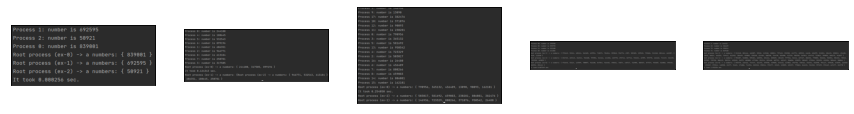

lol


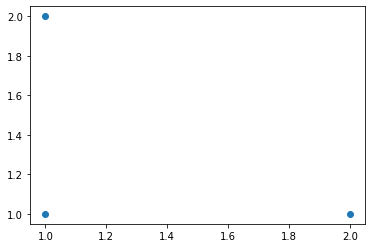

kek


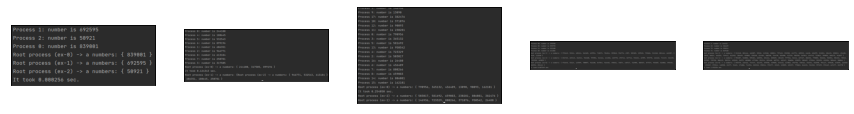

In [31]:
%matplotlib inline

from matplotlib.pyplot import subplots, imread, close, scatter, gcf
from IPython.display import display


def remove_axis(plt):
  plt.axes.xaxis.set_visible(False)
  plt.axes.yaxis.set_visible(False)

def print_images(path: str):
  figure, axes = subplots(1, 5, figsize=(15, 15))
  for ind, ax in enumerate(axes):
    remove_axis(ax)
    ax.imshow(imread(f"{path}/img{ind}.png"))
  display(figure)
  close()

print_images("./imgs")
print("lol")
scatter([1, 2, 1], [2, 1, 1])
display(gcf())
close()
print("kek")
print_images("./imgs")